In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import date, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
import mlflow.sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from pprint import pprint

import json
import pickle
from statsmodels.tsa.seasonal import STL


In [219]:
pickle_path = os.path.join('..', '..', 'data', 'features_by_date')
features_by_date = pd.read_pickle(pickle_path)
df_num_people=pd.Series(data=features_by_date['filled_num_people_11_30'].values, index=features_by_date.index)


def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    maloge=np.mean(np.abs(np.log(pred / actual)))
    return rmse, mae, r2,maloge

#params:
seasonal=23
train_test_boundary=150
rolling_avg=5
exp_rolling_avg_alpha=0.2
poly_features_deg=2





num_features = ['exp_rolling_avg','rolling_avg']  # 'exp_moving_avg_0.1','average_of_past_weeks','deviation_1_day_ago','deviation_2_day_ago','temp_deviation', 'Temperature', 'Rain Duration','Rain_half_discrete'
cat_features = []  # 'weekday']
cat_features_onehot = []  # 'w0','w1','w2','w3','w4']
bin_features = ['zuehlke_day']#'month_quarter_0','month_quarter_1','month_quarter_2','month_quarter_3','zuehlke_day','Spring/Autumn','Summer','Winter']  # 'Rain_binary','Spring/Autumn','Summer','Winter','zurich_vacation', 'zuehlke_day', 'Monday','Tuesday','Wednesday','Thursday','Friday','month_quarter_0'(1,2,3)
label = ['labels']

i=train_test_boundary+2
params={'alpha': 0.5, 'l1_ratio':0.5}
predictions=[]
coefficients = []


test_set=range(train_test_boundary, len(features_by_date))
#for i in test_set:
stl = STL(features_by_date.iloc[:i]['filled_num_people_11_30'], period=5, seasonal=seasonal, robust=True)
stl_res = stl.fit()
stl_res.seasonal[features_by_date.iloc[i]['date']]=stl_res.seasonal[features_by_date.iloc[i]['date']-timedelta(days=7)]
labels=features_by_date.iloc[:i+1]['filled_num_people_11_30'] -stl_res.seasonal
features_by_date['labels']=labels
features_by_date['rolling_avg']=labels.rolling(window=rolling_avg).mean().shift(1)
features_by_date['exp_rolling_avg']=labels.ewm(alpha=0.2).mean().shift(1)

column_transformer = ColumnTransformer([
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(), cat_features),
        ('bin', 'passthrough', bin_features)
    ])
pipe_estimator = Pipeline([
    ('column_transformer', column_transformer),
    ('poly_features', PolynomialFeatures(poly_features_deg)),
    ('scaler', StandardScaler()),
    ('estimator', ElasticNet(**params, random_state=42))
    # ('estimator', SVR(**params))
    # ('estimator', RandomForestRegressor(**params, random_state=42))

])
print(features_by_date[5:i]['date'])
pipe_estimator.fit(features_by_date[5:i], labels[5:i])
coefficients.append(pipe_estimator.named_steps['estimator'].coef_)
if i== test_set[-1]:
    train_predictions= pipe_estimator.predict(features_by_date[5:i])+stl_res.seasonal[5:i]
    print(f'Train_error: {eval_metrics(features_by_date[5:i]["filled_num_people_11_30"],train_predictions)}')
predictions.append(pipe_estimator.predict(features_by_date.iloc[i:i+1])[0]+stl_res.seasonal.iloc[-1])
#eval_metrics(features_by_date.iloc[test_set]['filled_num_people_11_30'],np.array(predictions))

2022-03-08    2022-03-08
2022-03-09    2022-03-09
2022-03-10    2022-03-10
2022-03-11    2022-03-11
2022-03-14    2022-03-14
                 ...    
2022-09-22    2022-09-22
2022-09-23    2022-09-23
2022-09-26    2022-09-26
2022-09-27    2022-09-27
2022-09-28    2022-09-28
Name: date, Length: 147, dtype: object


In [225]:
features_by_date['dif_labels_rolling_avg']=features_by_date['labels']-features_by_date['rolling_avg']
for i in range(1,6):
    features_by_date[f'dif_labels_rolling_avg_{i}_days_ago']= features_by_date['dif_labels_rolling_avg'].shift(i)
features_by_date

,date,num_people_10_00,label_num_people_12_33,label_num_people_11_30,label_num_menus_sold,label_difference_12_normalized,label_difference_10_and_sold_normalized,zurich_vacation,exp_moving_avg_0.1,log_exp_moving_avg_0.1,...,labels,rolling_avg,exp_rolling_avg,dif_labels_rolling_avg,dif_labels_rolling_avg_{i}_days_ago,dif_labels_rolling_avg_1_days_ago,dif_labels_rolling_avg_2_days_ago,dif_labels_rolling_avg_3_days_ago,dif_labels_rolling_avg_4_days_ago,dif_labels_rolling_avg_5_days_ago
2022-03-01,2022-03-01,144,152,159,NaN,-0.055556,NaN,0,NaN,NaN,...,140.592338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-02,2022-03-02,153,154,160,NaN,-0.006536,NaN,0,NaN,NaN,...,143.264438,NaN,140.592338,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-03,2022-03-03,122,119,132,NaN,0.024590,NaN,0,NaN,NaN,...,124.532465,NaN,142.076838,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-04,2022-03-04,86,62,87,NaN,0.279070,NaN,0,NaN,NaN,...,139.526539,NaN,134.886521,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-07,2022-03-07,128,136,132,NaN,-0.062500,NaN,0,NaN,NaN,...,122.547685,NaN,136.458343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,2022-12-01,218,195,216,NaN,0.105505,NaN,0,203.150887,5.313949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-02,2022-12-02,119,118,130,NaN,0.008403,NaN,0,108.291627,4.684828,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-05,2022-12-05,163,150,169,NaN,0.079755,NaN,0,180.256250,5.194379,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-06,2022-12-06,202,184,206,NaN,0.089109,NaN,0,207.328034,5.334302,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0.39573468738837836


<AxesSubplot: >

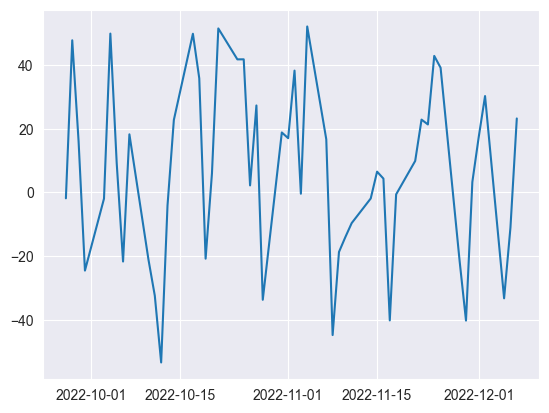

In [189]:
print((features_by_date.iloc[test_set]['filled_num_people_11_30']-(np.array(predictions))-6).mean())
(features_by_date.iloc[test_set]['filled_num_people_11_30']-predictions).plot()

In [138]:
labels

2022-03-01    137.565656
2022-03-02    138.509032
2022-03-03    125.443594
2022-03-04    146.016848
2022-03-07    122.164158
                 ...    
2022-12-01    201.371520
2022-12-02    203.041891
2022-12-05    172.261894
2022-12-06    187.905882
2022-12-07    203.306664
Length: 202, dtype: float64

In [146]:
preds=pd.DataFrame(data=predictions,index=features_by_date.iloc[train_test_boundary:].index)

In [147]:
preds.join(features_by_date.iloc[train_test_boundary:]['filled_num_people_11_30'])

,0,filled_num_people_11_30
2022-09-27,206.884895,195.0
2022-09-28,222.021980,303.0
2022-09-29,203.393280,222.0
2022-09-30,84.694806,75.0
2022-10-03,158.252838,172.0
2022-10-04,213.139497,249.0
2022-10-05,238.308979,251.0
2022-10-06,230.339242,197.0
2022-10-07,63.461285,104.0
2022-10-10,160.388498,154.0


In [84]:
for i in test_set:
    stl = STL(train_set['filled_num_people_11_30'], period=5, seasonal=13, robust=True)
    stl_res = stl.fit()
    labels=train_set['filled_num_people_11_30']- stl_res.seasonal
    train_set['labels']=labels
    train_set['rolling_avg']=labels.rolling(rolling_avg).mean().shift(1)
    train_set['exp_rolling_avg']=labels.ewm(alpha=0.2).mean().shift(1)

    column_transformer = ColumnTransformer([
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(), cat_features),
        ('bin', 'passthrough', bin_features)
    ])
    pipe_estimator = Pipeline([
        ('column_transformer', column_transformer),
        ('poly_features', PolynomialFeatures(poly_features_deg)),
        ('scaler', StandardScaler()),
        ('estimator', ElasticNet(**params, random_state=42))
        # ('estimator', SVR(**params))
        # ('estimator', RandomForestRegressor(**params, random_state=42))

    ])
    pipe_estimator.fit(features_by_date[1:i], labels[1:i])
    coefficients.append(pipe_estimator.named_steps['estimator'].coef_)
    predictions.append(pipe_estimator.predict(features_by_date.iloc[i:i+1])[0])
eval_metrics(predictions,labels.iloc[test_set])

2022-09-27     6.624186
2022-09-28    54.287096
2022-09-29    24.937270
2022-09-30   -16.411804
2022-10-03     3.188358
2022-10-04    45.370461
2022-10-05    28.364964
2022-10-06    -8.978631
2022-10-07     4.097682
2022-10-10   -17.285004
dtype: float64

In [58]:
params={'alpha': 0.5, 'l1_ratio':0.5}
def train_model(params):


    column_transformer = ColumnTransformer([
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(), cat_features),
        ('bin', 'passthrough', bin_features)
    ])
    pipe_estimator = Pipeline([
        ('column_transformer', column_transformer),
        ('poly_features', PolynomialFeatures(poly_features_deg)),
        ('scaler', StandardScaler()),
        ('estimator', ElasticNet(**params, random_state=42))
        # ('estimator', SVR(**params))
        # ('estimator', RandomForestRegressor(**params, random_state=42))

    ])

    errors = []
    coefficients = []
    for i in range(train_test_boundary, len(features_by_date)):

    for i in range(0, num_validation_steps):
        pipe_estimator.fit(train_x[i], train_y[i])
        coefficients.append(pipe_estimator.named_steps['estimator'].coef_)
        #eval_metrics(train_y[i], pipe_estimator.predict(train_x[i]))
        predictions = pipe_estimator.predict(test_x[i])
        errors.append(eval_metrics(test_y[i], predictions))
    rmse_mean, mae_mean, r2_mean, maloge = np.mean(errors, axis=0)
    print('params:')
    print(params)
    print(f'rmse : {rmse_mean}')  # , mae : {mae_mean} , r2 : {r2_mean}')
    return (rmse_mean, mae_mean, r2_mean, maloge), pipe_estimator, coefficients

2022-03-01    137.485408
2022-03-02    138.394367
2022-03-03    125.470664
2022-03-04    146.114440
2022-03-07    122.233695
                 ...    
2022-09-20    198.536236
2022-09-21    173.819722
2022-09-22    182.403641
2022-09-23    206.149822
2022-09-26    165.738608
Length: 150, dtype: float64

In [197]:
def func(a,b,c):

    return a+b+c

dict_abc={'a':1,'b':2,'c':3}
func(**dict_abc)

6

In [198]:
**dict_abc

SyntaxError: invalid syntax (2583626195.py, line 1)